# Smoothing and Resampling Test Case - SRCNet v0.1
---

**Test name:** SWF-003-T1 – Smoothing and resampling of miilti-frequency datasets using astopy

**Author:** Mertens Florent, Adélie Gorce and Teal team 

**Documentation on confluence:** https://confluence.skatelescope.org/pages/viewpage.action?pageId=319987925

**Summary:**  This test assesses the ability of the SRCNet v0.1 pipeline to perform spatial smoothing and resampling on multi-frequency 2D images to a common resolution. The main applications include spectral energy distribution (SED) extraction and spectral index mapping, which require data aligned to a shared PSF and pixel grid.

---

### Data:
We use real data from the **EMU survey** (ASKAP continuum images) at two frequencies, and one X-ray image from the XMM-Newton telescope all publicaly available.

### In this test we perform:

- Convolution with a common elliptical kernel to match resolution (PSF)
- Visualisation of maps and spectral index
- Pixel-based extraction of fluxes and spectral indices
- Region selection tools to define cutouts

### Expected outputs:
- Multi-frequency images smoothed and resampled to a common resolution/grid
- Sepctral index map
- Peak flux and spectral index of bright sources in the image
  
### Outputs for validation: 
- Output is validated by comparing images between output of test on SRCNet and test ran on known infrastructure. See https://confluence.skatelescope.org/pages/viewpage.action?pageId=319987925 for expected outputs



In [1]:
import os
import yaml
import warnings 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector

from scipy.ndimage import maximum_filter
from scipy.stats import describe, median_abs_deviation

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.nddata.utils import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord

from reproject import reproject_interp


# Optional: use inline if not working
%matplotlib inline

In [2]:
# Function to convert FWHM to sigma in pixels
def fwhm_to_sigma(fwhm, pixscale):
    return (fwhm / pixscale) / np.sqrt(8 * np.log(2))

# Function to create 2D elliptical Gaussian kernel
def elliptical_gaussian_kernel(sigma_maj, sigma_min, theta_deg, size=None):
    if not size:
        size = int(10 * max(sigma_maj, sigma_min))
    g = Gaussian2D(1, x_mean=size // 2, y_mean=size // 2, x_stddev=sigma_maj, y_stddev=sigma_min, theta=np.radians(theta_deg))
    y, x = np.mgrid[0:size, 0:size]
    return g(x, y)

# Function to compute the beam area
def beam_area(bmaj, bmin):
    return (np.pi / (4 * np.log(2))) * bmaj.to(u.deg).value * bmin.to(u.deg).value


### Data retrieval

We use data from the ASKAP Pilot Survey for EMU project (AS101) and from the XMM X-ray telescope.

The code snippet below demonstrates how to download the required ASKAP FITS files using astroquery. The code for downloading the XMM dataset is provided later in this notebook, at the point where the dataset is needed.

In [3]:
# from astroquery.casda import Casda

# casda = Casda()
# username = 'YOUR_OPAL_USERNAME'  # Replace with your OPAL username
# casda.login(username=username)

# result_table = casda.query_region(SkyCoord(ra=238.0, dec=-55.0, unit=(u.deg, u.deg)), radius=0.2 * u.deg)

# # List of target filenames
# target_filenames = [
#     'image.i.EMU_1554-55_band1.SB43773.cont.taylor.0.restored.fits',
#     'image.i.EMU_1554-55_band2.SB40625.cont.taylor.0.restored.fits'
# ]

# files = result_table[np.isin(result_table['filename'], target_filenames)]
# staged_data = casda.stage_data(files)
# downloaded_files = casda.download_files(staged_data, savedir='.')

### Data Location

Set here the root directory of the fits files

In [4]:
# File paths
# base_path = "/project/test_campaign/test_datasets"
# result_path = ''

config_file = "../config/config.yml"


#base_path = "/net/node101/data/users/lofareor/mertens/srcnet/data/swf003-t1"
#result_path = "/net/node101/data/users/lofareor/mertens/srcnet/results/swf003-t1"
default_base_path = "../datasets"
default_result_path = "../results"

if os.path.exists(config_file):
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)
else:
    warnings.warn(f"! Configuration file '{config_file}' not found. Using default settings.", UserWarning)
    config = {}

base_path = config.get("data_path")
if base_path is None:
    warnings.warn(f"! 'data_path' not found in '{config_file}'. Using default path '{default_base_path}'.", UserWarning)
    base_path = default_base_path

result_path = config.get("result_path")
if result_path is None:
    warnings.warn(f"! 'result_path' not found in '{config_file}'. Using default: '{default_result_path}'.", UserWarning)
    result_path = default_result_path

result_path += "/SWF-003-T1"


file1 = base_path + "/image.i.EMU_1554-55_band2.SB40625.cont.taylor.0.restored.fits"
file2 = base_path + "/image.i.EMU_1554-55_band1.SB43773.cont.taylor.0.restored.fits"
file_xmm = base_path + "/P0204270101EPX0003COLIM8000.FIT"

if not os.path.exists(result_path):
    os.makedirs(result_path)

### Load FITS images and extract metadata

In this step, we load two EMU continuum images at different frequencies and extract metadata

In [5]:
# Load FITS files
hdul1 = fits.open(file1)
hdul2 = fits.open(file2)

data1 = hdul1[0].data.squeeze()
data2 = hdul2[0].data.squeeze()

header1 = hdul1[0].header
header2 = hdul2[0].header

wcs1 = WCS(header1).celestial
wcs2 = WCS(header2).celestial

# Get the reference frequency (CRVAL along spectral axis)
freq1 = header1['CRVAL3']
freq2 = header2['CRVAL3']

print(f"Frequency 1: {freq1 / 1e6:.1f} MHz")
print(f"Frequency 2: {freq2 / 1e6:.1f} MHz")

# Pixel scale from CDELT1 (assumes square pixels)
pixscale1 = abs(header1['CDELT1']) * u.deg
pixscale2 = abs(header2['CDELT1']) * u.deg

print(f"Pixel scale image 1: {pixscale1.to(u.arcsec):.2f}")
print(f"Pixel scale image 2: {pixscale2.to(u.arcsec):.2f}")

# Beam sizes from BMAJ/BMIN
bmaj1 = header1.get("BMAJ", np.nan) * u.deg
bmin1 = header1.get("BMIN", np.nan) * u.deg
bmaj2 = header2.get("BMAJ", np.nan) * u.deg
bmin2 = header2.get("BMIN", np.nan) * u.deg
bpa1 = header1['BPA']
bpa2 = header2['BPA']

print(f"Beam image 1: BMAJ = {bmaj1.to(u.arcsec):.2f}, BMIN = {bmin1.to(u.arcsec):.2f}")
print(f"Beam image 2: BMAJ = {bmaj2.to(u.arcsec):.2f}, BMIN = {bmin2.to(u.arcsec):.2f}")

# Pointing centres from CRVAL1/CRVAL2
ra1 = header1['CRVAL1']
dec1 = header1['CRVAL2']
ra2 = header2['CRVAL1']
dec2 = header2['CRVAL2']

print(f"Pointing centre image 1: RA = {ra1:.6f} deg, Dec = {dec1:.6f} deg")
print(f"Pointing centre image 2: RA = {ra2:.6f} deg, Dec = {dec2:.6f} deg")


Frequency 1: 1367.5 MHz
Frequency 2: 943.5 MHz
Pixel scale image 1: 2.00 arcsec
Pixel scale image 2: 2.00 arcsec
Beam image 1: BMAJ = 8.55 arcsec, BMIN = 7.50 arcsec
Beam image 2: BMAJ = 12.13 arcsec, BMIN = 10.50 arcsec
Pointing centre image 1: RA = 238.500000 deg, Dec = -55.724836 deg
Pointing centre image 2: RA = 238.500000 deg, Dec = -55.724836 deg


Set OBSGEO-B to   -26.704100 from OBSGEO-[XYZ].
Set OBSGEO-H to      121.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


### Visualisation of Full EMU Images

We display the two EMU continuum images side by side.

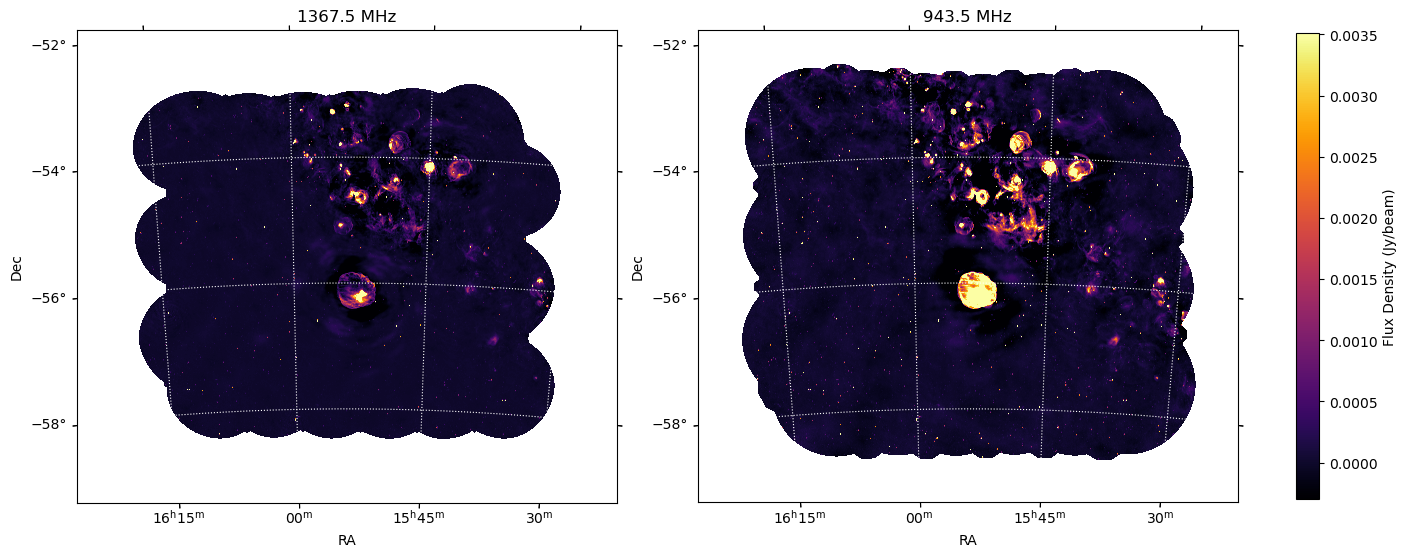

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, subplot_kw={'projection': wcs1}, layout='constrained')

vmin, vmax = np.nanpercentile(data2, [5, 99])

# Image 1
im1 = axes[0].imshow(data1, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[0].set_title(f"{freq1 / 1e6:.1f} MHz")
axes[0].set_xlabel("RA")
axes[0].set_ylabel("Dec")
axes[0].coords.grid(True, color='white', ls='dotted')

# Image 2
im2 = axes[1].imshow(data2, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[1].set_title(f"{freq2 / 1e6:.1f} MHz")
axes[1].set_xlabel("RA")
axes[1].set_ylabel("Dec")
axes[1].coords.grid(True, color='white', ls='dotted')

# Shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='vertical', shrink=0.85)
cbar.set_label("Flux Density (Jy/beam)")


### Extracting Image Cutouts

We extract cutouts of a set size from both EMU images, centred at a set pixel coordinates.

An (optional) interactactive widget is used to extract center and size of a cutout.

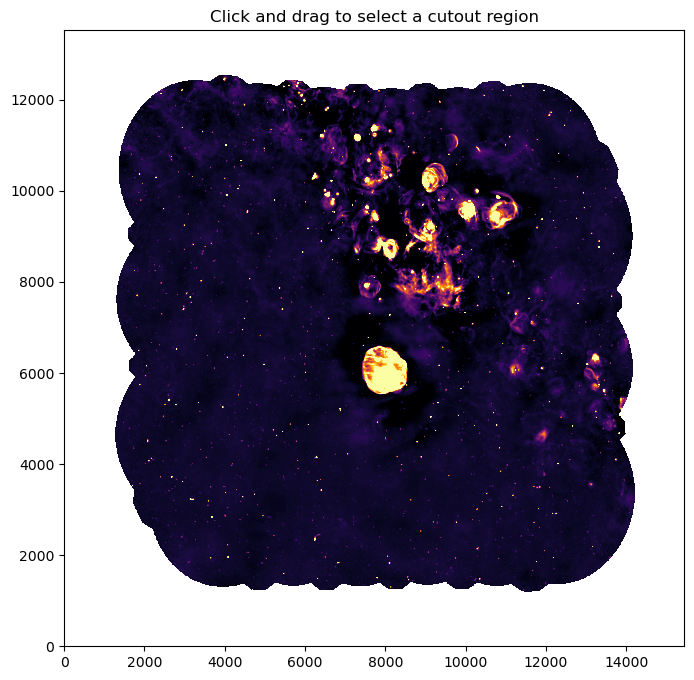

In [7]:
# Store result
cutout_info = {}

vmin, vmax = np.nanpercentile(data2, [5, 99])

# Callback function
def line_select_callback(eclick, erelease):
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    print(x1, y1, x2, y2)
    x_center = (x1 + x2) // 2
    y_center = (y1 + y2) // 2
    width = abs(x2 - x1)
    height = abs(y2 - y1)
    cutout_info['position'] = (x_center, y_center)
    cutout_info['size'] = (width, height)
    title = f"Center: ({x_center}, {y_center}) | Size: ({width}, {height})"
    title = f"X1: ({x1}, {y1}) | X2: ({x2}, {y2})"
    ax.set_title(title)
    fig.canvas.draw_idle()

# Plot image
fig, ax = plt.subplots(figsize=(8, 8))
extent = [0, data2.shape[1], 0, data2.shape[0]]
ax.imshow(data2[::10, ::10], origin='lower', cmap='inferno', extent=extent, vmin=vmin, vmax=vmax)
ax.set_title("Click and drag to select a cutout region")
ax.set_aspect('auto')

# RectangleSelector
selector = RectangleSelector(ax, line_select_callback, useblit=True, button=[1], minspanx=5, minspany=5, 
                             spancoords='pixels', interactive=True)


In [8]:
# use cutout info from selection. Otherwise, if no region was selected or inter88 * u.imperial.mile / u.houractive element is disabled, a default region will be selected.
if 'position' in cutout_info:
    # use cutout info from selection 
    position = cutout_info['position']
    size = np.array(cutout_info['size'])[::-1]
else:
    # use default region selection
    position = (8000, 6000)
    size = (1500, 1500)

# Other interesting regions in the images can be selected below
# position = (9000, 8000)
# size = (2000, 2000)

# position = (8000, 6000)
# size = (1500, 1500)

# position = (4000, 5000)
# size = (2000, 2000)

cutout1 = Cutout2D(data1, position, size, wcs1)
cutout2 = Cutout2D(data2, position, size, wcs2)

sky_coord_center = pixel_to_skycoord(*position, wcs2)

print(f"Cutout position (pixels): x = {position[0]}, y = {position[1]}")
print(f"Cutout size (pixels): width = {size[1]}, height = {size[0]}")
print(f"Cutout center (sky): RA = {sky_coord_center.ra.deg:.5f} deg, Dec = {sky_coord_center.dec.deg:.5f} deg")

Cutout position (pixels): x = 8000, y = 6000
Cutout size (pixels): width = 1500, height = 1500
Cutout center (sky): RA = 238.21672 deg, Dec = -56.15341 deg


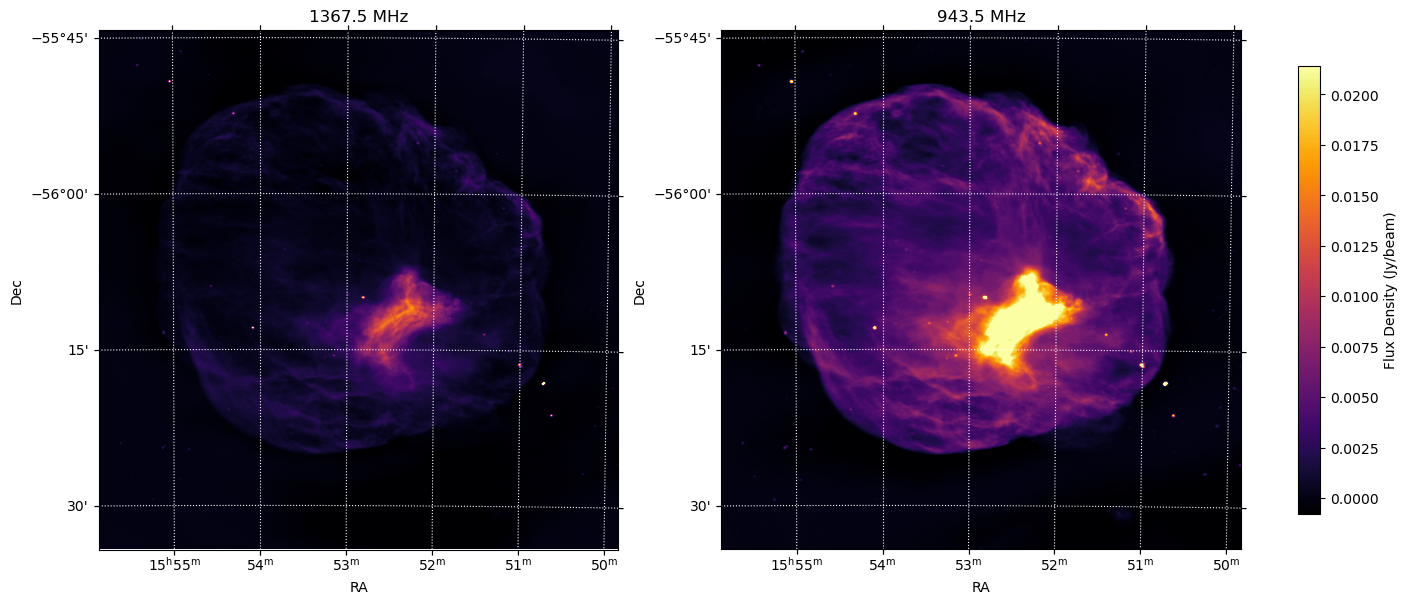

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, subplot_kw={'projection': cutout1.wcs}, layout='constrained')

vmin, vmax = np.nanpercentile(cutout2.data, [5, 99])

# Image 1
im1 = axes[0].imshow(cutout1.data, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[0].set_title(f"{freq1 / 1e6:.1f} MHz")
axes[0].set_xlabel("RA")
axes[0].set_ylabel("Dec")
axes[0].coords.grid(True, color='white', ls='dotted')

# Image 2
im2 = axes[1].imshow(cutout2.data, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[1].set_title(f"{freq2 / 1e6:.1f} MHz")
axes[1].set_xlabel("RA")
axes[1].set_ylabel("Dec")
axes[1].coords.grid(True, color='white', ls='dotted')

# Shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='vertical', shrink=0.85)
cbar.set_label("Flux Density (Jy/beam)")

fig.savefig(f'{result_path}/ASKAP_MF_maps_before_smoothing_position_RA_{sky_coord_center.ra.deg:.2f}deg_DEC_{sky_coord_center.dec.deg:.2f}deg.png', dpi=180)

### Smoothing to a Common Elliptical Beam

To ensure consistent resolution between the two EMU images, we smooth both cutouts using the same elliptical Gaussian kernel. The target beam is defined as:

- **BMAJ / BMIN**: the maximum of the two input beams along each axis
- **BPA**: the average position angle, assuming the beams are similarly oriented

It is also possible to set a target bmaj/bmin/bpa 

In [10]:
# Determine target beam
target_bmaj = max(bmaj1, bmaj2)
target_bmin = max(bmin1, bmin2)
target_bpa = np.mean([bpa1, bpa2])  # BPA should be similar between maps

# Optionally override with a fixed beam
target_bmaj = 15 * u.arcsec
target_bmin = 15 * u.arcsec
target_bpa = 0

# Create elliptical Gaussian kernel
sigma_maj = fwhm_to_sigma(target_bmaj, pixscale1).si
sigma_min = fwhm_to_sigma(target_bmin, pixscale1).si
kernel = elliptical_gaussian_kernel(sigma_maj, sigma_min, target_bpa)

# Smooth both cutouts with the same kernel
smooth1 = convolve_fft(cutout1.data, kernel)
smooth2 = convolve_fft(cutout2.data, kernel)

# Convert from Jy/PSF_orig -> Jy/pix -> Jy/PSF_target
area1 = beam_area(bmaj1, bmin1)
area2 = beam_area(bmaj2, bmin2)
area_target = beam_area(target_bmaj, target_bmin)
scale1 = area_target / area1
scale2 = area_target / area2

smooth1 = smooth1 * scale1
smooth2 = smooth2 * scale2

# Print summary
print(f"Applied elliptical Gaussian smoothing:")
print(f"  Target BMAJ = {target_bmaj.to(u.arcsec):.2f}, BMIN = {target_bmin.to(u.arcsec):.2f}, BPA = {target_bpa:.2f}°")
print(f"  Pixel scale = {pixscale1 * 3600:.2f} arcsec/pixel")
print(f"  Flux rescaling factors: {scale1:.3f} (map1), {scale2:.3f} (map2)")


Applied elliptical Gaussian smoothing:
  Target BMAJ = 15.00 arcsec, BMIN = 15.00 arcsec, BPA = 0.00°
  Pixel scale = 2.00 deg arcsec/pixel
  Flux rescaling factors: 3.508 (map1), 1.767 (map2)


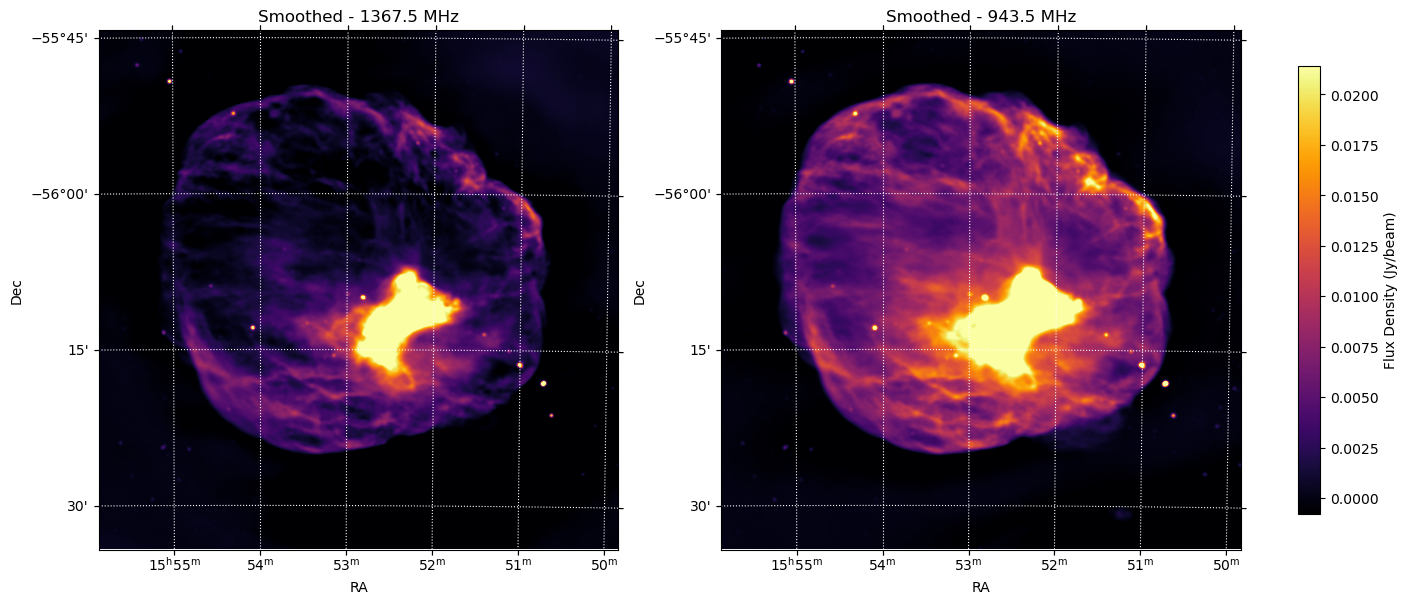

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, subplot_kw={'projection': cutout2.wcs}, layout='constrained')

vmin, vmax = np.nanpercentile(cutout2.data, [5, 99])

# Image 1
im1 = axes[0].imshow(smooth1, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[0].set_title(f"Smoothed - {freq1 / 1e6:.1f} MHz")
axes[0].set_xlabel("RA")
axes[0].set_ylabel("Dec")
axes[0].coords.grid(True, color='white', ls='dotted')

# Image 2
im2 = axes[1].imshow(smooth2, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[1].set_title(f"Smoothed - {freq2 / 1e6:.1f} MHz")
axes[1].set_xlabel("RA")
axes[1].set_ylabel("Dec")
axes[1].coords.grid(True, color='white', ls='dotted')

# Shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='vertical', shrink=0.85)
cbar.set_label("Flux Density (Jy/beam)")

fig.savefig(f'{result_path}/ASKAP_MF_maps_after_smoothing_position_RA_{sky_coord_center.ra.deg:.2f}deg_DEC_{sky_coord_center.dec.deg:.2f}deg.png', dpi=180)

### Spectral Index Map

We compute the spectral index α using the smoothed cutouts at two frequencies with the standard two-point formula:

alpha = log(S2 / S1) / log(nu2 / nu1)

where S1 and S2 are the flux densities at frequencies nu1 and nu2, respectively. To avoid unreliable values, pixels where the second map has flux below 0.2 mJy/beam are masked out.


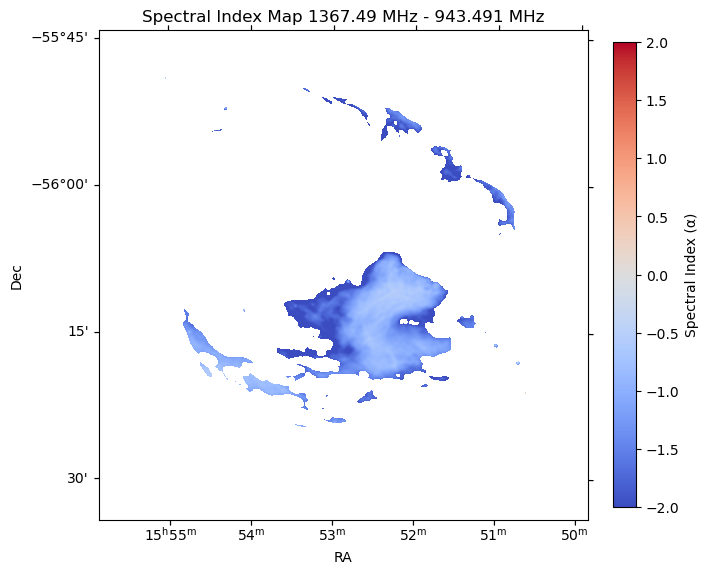

In [12]:
# Compute spectral index map, on a valid region
n_sigma_theshold = 3
rms = median_abs_deviation(smooth1.flatten(), scale='normal', nan_policy='omit')
valid = (smooth1 > n_sigma_theshold * rms)
alpha = np.full_like(smooth1, np.nan)
alpha[valid] = np.log(smooth2[valid] / smooth1[valid]) / np.log(freq2 / freq1)

# Plot
fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': cutout2.wcs}, layout='constrained')

im = ax.imshow(alpha, origin='lower', cmap='coolwarm', vmin=-2, vmax=2)
ax.set_title(f"Spectral Index Map {freq1 * 1e-6} MHz - {freq2 * 1e-6} MHz")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
# ax.coords.grid(True, color='black', ls='dotted')

cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.85)
cbar.set_label("Spectral Index (α)")

fig.savefig(f'{result_path}/ASKAP_MF_spectral_index_map_position_RA_{sky_coord_center.ra.deg:.2f}deg_DEC_{sky_coord_center.dec.deg:.2f}deg.png', dpi=180)

Now we compute image statistics and generate histograms from the alpha distribution:

In [13]:
nobs, minmax, mean, variance, skewness, kurtosis = describe(alpha[~np.isnan(alpha)])
print(f'The alpha distribution has mean {mean:.2f}, variance {variance:.2f}, skewness {skewness:.2f}, and kurtosis {kurtosis:.2f}.')
print(f'The minimum value is {minmax[0]:.2f} and the maximum value is {minmax[1]:.2f}.')

The alpha distribution has mean -1.41, variance 0.26, skewness -0.31, and kurtosis -0.88.
The minimum value is -2.91 and the maximum value is 0.73.


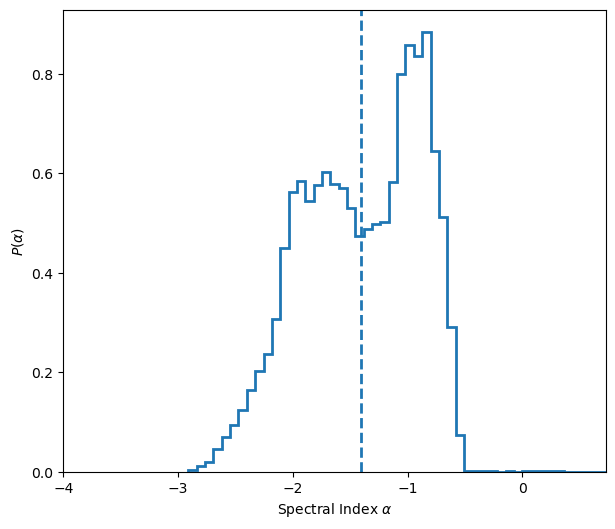

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))
_ = ax.hist(alpha[~np.isnan(alpha)], bins=50, color='C0', lw=2., range=minmax, histtype='step', density=True)
ax.axvline(mean, color='C0', lw=2., ls='--', label='Mean')
ax.set_xlim(-4, minmax[1])
ax.set_xlabel(r"Spectral Index $\alpha$")
ax.set_ylabel(r'$P(\alpha)$')
fig.savefig(f'{result_path}/ASKAP_MF_spectral_index_histo_position_RA_{sky_coord_center.ra.deg:.2f}deg_DEC_{sky_coord_center.dec.deg:.2f}deg.png', dpi=180)

### Spectra Index of Brightest Point-like Sources

To identify the brightest compact sources in the cutout, we apply a simple peak-finding method:

- A **maximum filter** is used to locate local maxima within a sliding window of 10×10 pixels.
- From the resulting local peaks, we extract the top 5 brightest sources based on their flux values in the higher-frequency map.

We then extract the corresponding flux values and spectra index


Text(0.5, 1.0, 'Top 5 Brightest Sources')

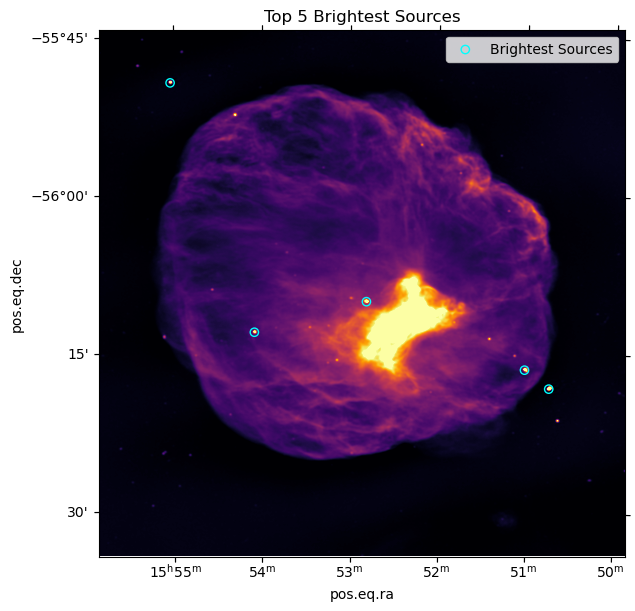

In [15]:
# Parameters
data = cutout2.data
window_size = 2 * max(sigma_maj, sigma_min).value
n_sources = 5

# Apply maximum filter to find local peaks
local_max = maximum_filter(data, size=window_size) == data

# Mask: valid pixels only (finite and positive)
mask = np.isfinite(data) & (data > 0)

# Combine masks
peaks_mask = local_max & mask

# Get coordinates and values of peaks
y, x = np.where(peaks_mask)
peak_values = data[y, x]
peak_values1 = cutout1.data[y, x]

# Sort by brightness
sorted_indices = np.argsort(peak_values)[::-1]
top_x = x[sorted_indices][:n_sources]
top_y = y[sorted_indices][:n_sources]
top_fluxes = peak_values[sorted_indices][:n_sources]
top_fluxes1 = peak_values1[sorted_indices][:n_sources]

fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': cutout2.wcs}, layout='constrained')
ax.imshow(data, origin='lower', cmap='inferno', vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 99))
ax.scatter(top_x, top_y, marker='o', facecolors='none', edgecolors='cyan', label='Brightest Sources')
ax.legend()
ax.set_title(f"Top {n_sources} Brightest Sources")


In [16]:
# Convert pixel coordinates to sky coordinates (RA/Dec)
sky_coords = pixel_to_skycoord(top_x, top_y, cutout2.wcs)

# Extract spectral index values at these positions
top_alphas = alpha[top_y, top_x]

# Print results
print(f"Top {n_sources} brightest point-like sources:")
for i in range(n_sources):
    ra_str = sky_coords[i].ra.to_string(unit=u.hour, sep=':', precision=2)
    dec_str = sky_coords[i].dec.to_string(unit=u.deg, sep=':', precision=2)
    print(f"{i+1:2d}. RA = {ra_str}, Dec = {dec_str} | "
          f"Flux1 = {top_fluxes1[i]:.3f}, Flux2 = {top_fluxes[i]:.3f} | "
          f"α = {top_alphas[i]:.2f}")


Top 5 brightest point-like sources:
 1. RA = 15:50:44.13, Dec = -56:18:11.86 | Flux1 = 0.065, Flux2 = 0.121 | α = -0.62
 2. RA = 15:52:49.11, Dec = -56:10:02.17 | Flux1 = 0.035, Flux2 = 0.070 | α = -1.12
 3. RA = 15:54:05.51, Dec = -56:12:57.43 | Flux1 = 0.036, Flux2 = 0.057 | α = -0.72
 4. RA = 15:55:02.42, Dec = -55:49:16.42 | Flux1 = 0.034, Flux2 = 0.057 | α = -0.52
 5. RA = 15:51:00.85, Dec = -56:16:25.41 | Flux1 = 0.029, Flux2 = 0.055 | α = -0.84


## Comparison with XMM image

Now we will compare our ASKAP image to a XMM image of the same field, centered on the SNR G326.2-01.7. We first download the data from the XMM Newton archive using astroquery.

In [17]:
# If XMM fits file is not found, downlad it
if not os.path.exists(file_xmm):
    import tarfile
    import gzip
    import shutil
    
    from astroquery.esa.xmm_newton import XMMNewton
    
    obsid = "0204270101"
    XMMNewton.download_data(obsid, level='PPS', cache=False)
    
    tar_file = f"{obsid}.tar"
    target_filename = "P0204270101EPX0003COLIM8000.FTZ"
    output_fits = target_filename.replace(".FTZ", ".FIT")
    
    with tarfile.open(tar_file, "r") as tar:
        member = next((m for m in tar.getmembers() if m.name.endswith("/" + target_filename)), None)
        with tar.extractfile(member) as compressed:
            with gzip.open(compressed, 'rb') as f_in:
                with open(output_fits, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
    
    file_xmm = output_fits

In [18]:
# Load the XMM FITS file
hdul_xmm = fits.open(file_xmm)
data_xmm = hdul_xmm[0].data.squeeze()
header_xmm = hdul_xmm[0].header

# Get WCS
wcs_xmm = WCS(header_xmm).celestial

# Pixel scale
pixscale_xmm = abs(header_xmm.get('CDELT1', np.nan)) * u.deg
print(f"Pixel scale (XMM image): {pixscale_xmm.to(u.arcsec):.2f}")

# Pointing centre
ra_xmm = header_xmm['CRVAL1']
dec_xmm = header_xmm['CRVAL2']
print(f"Pointing centre (XMM image): RA = {ra_xmm:.6f} deg, Dec = {dec_xmm:.6f} deg")

# Use a cutout centered on 
position = (8000, 6000)
size = (1500, 1500)
cutout1 = Cutout2D(data1, position, size, wcs1)
cutout2 = Cutout2D(data2, position, size, wcs2)

Pixel scale (XMM image): 4.00 arcsec
Pointing centre (XMM image): RA = 238.076458 deg, Dec = -56.330222 deg


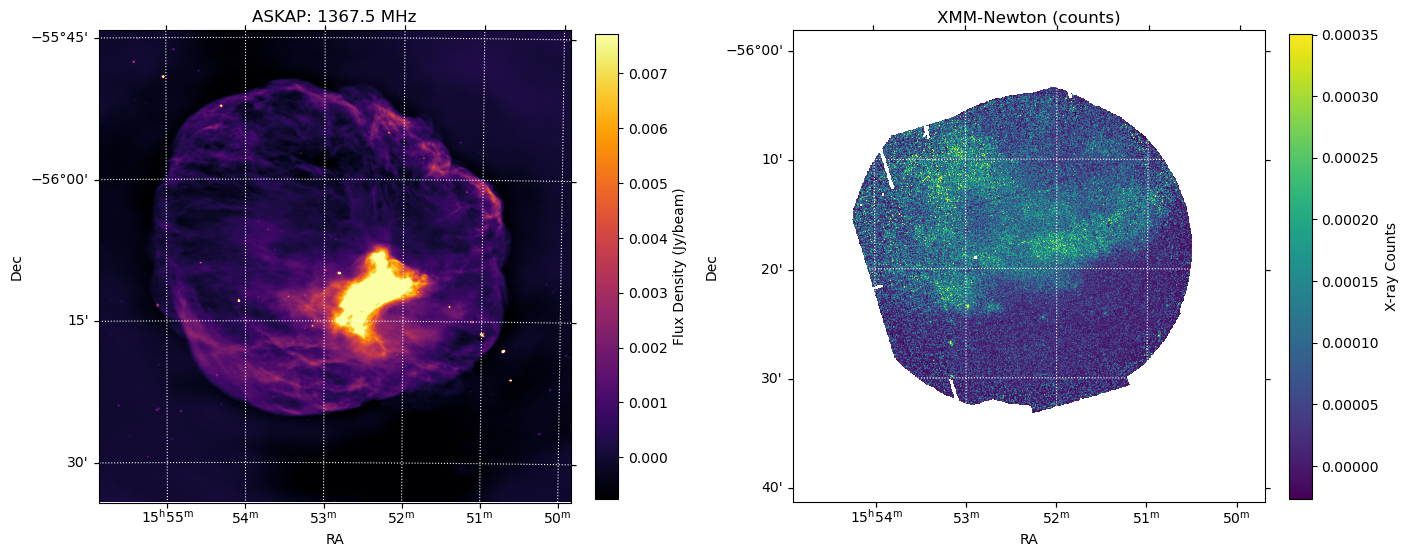

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Compute display ranges separately
vmin1, vmax1 = np.nanpercentile(cutout1.data, [5, 99])
vmin2, vmax2 = np.nanpercentile(data_xmm, [5, 99])

# Create figure
fig = plt.figure(figsize=(14, 6), layout='constrained')

# First panel: ASKAP image
ax1 = fig.add_subplot(1, 2, 1, projection=cutout1.wcs)
im1 = ax1.imshow(cutout1.data, origin='lower', cmap='inferno', vmin=vmin1, vmax=vmax1)
ax1.set_title(f"ASKAP: {freq1 / 1e6:.1f} MHz")
ax1.set_xlabel("RA")
ax1.set_ylabel("Dec")
ax1.coords.grid(True, color='white', ls='dotted')
ax1.coords[0].set_axislabel("RA")
ax1.coords[1].set_axislabel("Dec")

# Second panel: XMM image
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_xmm)
im2 = ax2.imshow(data_xmm[1], origin='lower', cmap='viridis', vmin=vmin2, vmax=vmax2)
ax2.set_title("XMM-Newton (counts)")
ax2.set_xlabel("RA")
ax2.set_ylabel("Dec")
ax2.coords.grid(True, color='white', ls='dotted')
ax2.coords[0].set_axislabel("RA")
ax2.coords[1].set_axislabel("Dec")

# Colorbars for each
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', shrink=0.85)
cbar1.set_label("Flux Density (Jy/beam)")

cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', shrink=0.85)
cbar2.set_label("X-ray Counts")

fig.savefig(f'{result_path}/ASKAP_XMM_before_resampling_position_RA_{sky_coord_center.ra.deg:.2f}deg_DEC_{sky_coord_center.dec.deg:.2f}deg.png', dpi=180)

## Resample and smooth

Here we will resample the XMM image to match the ASKAP image and smooth it to have the same resolution

In [20]:
# Reproject XMM to match ASKAP cutout1
reproj_xmm_data, _ = reproject_interp((data_xmm[1], wcs_xmm), cutout1.wcs, shape_out=cutout1.data.shape)

# Convolve the resampled image
# Optionally override with a fixed beam
xmm_target_fwhm = 80 * u.arcsec
xmm_sigma = fwhm_to_sigma(xmm_target_fwhm, pixscale_xmm).si
kernel = elliptical_gaussian_kernel(xmm_sigma, xmm_sigma, target_bpa)

smoothed_xmm = convolve_fft(reproj_xmm_data, kernel, preserve_nan=True)

smooth1 = convolve_fft(cutout1.data, kernel)

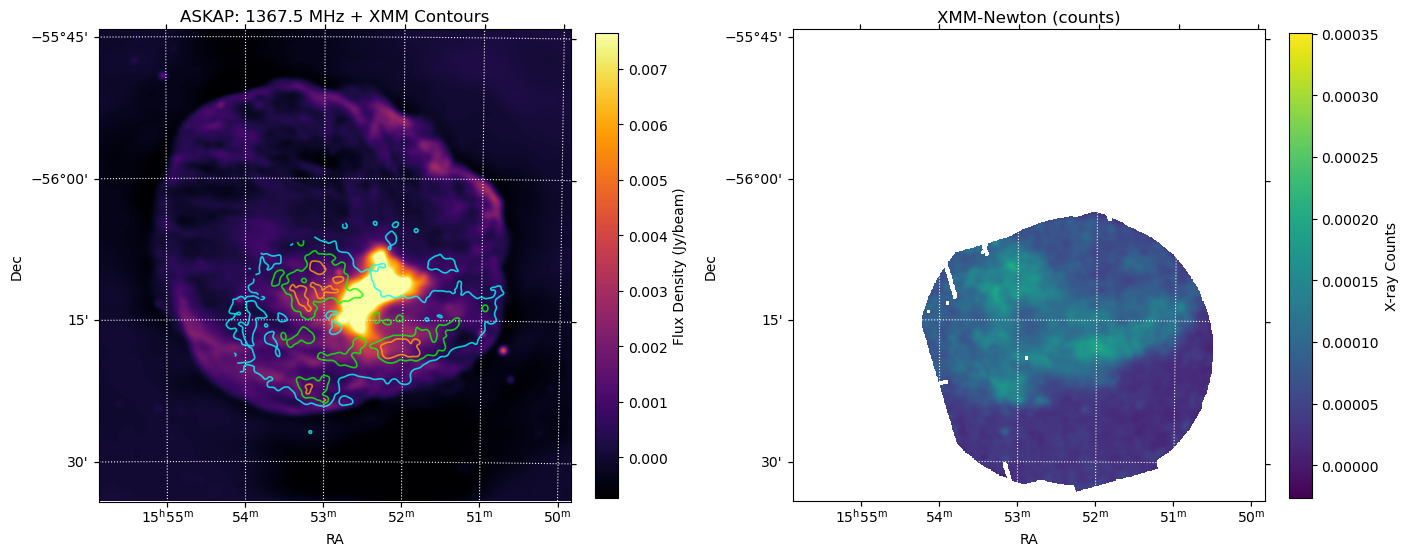

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Compute display ranges separately
vmin1, vmax1 = np.nanpercentile(smooth1, [5, 99])
vmin2, vmax2 = np.nanpercentile(data_xmm, [5, 99])

# Contour levels for XMM
contour_levels = np.nanpercentile(smoothed_xmm, [ 60, 90, 98])  # you can adjust as needed

fig = plt.figure(figsize=(14, 6), layout='constrained')

# First panel: ASKAP image
ax1 = fig.add_subplot(1, 2, 1, projection=cutout1.wcs)
im1 = ax1.imshow(smooth1, origin='lower', cmap='inferno', vmin=vmin1, vmax=vmax1)
ax1.set_title(f"ASKAP: {freq1 / 1e6:.1f} MHz + XMM Contours")
ax1.set_xlabel("RA")
ax1.set_ylabel("Dec")
ax1.coords.grid(True, color='white', ls='dotted')
ax1.coords[0].set_axislabel("RA")
ax1.coords[1].set_axislabel("Dec")

# Overlay XMM contours
colors = ['cyan', 'lime', 'orange']  # one per level
ax1.contour(smoothed_xmm, levels=contour_levels, colors=colors, linewidths=1.2, alpha=0.8)


# Second panel: XMM image
ax2 = fig.add_subplot(1, 2, 2, projection=cutout1.wcs)
im2 = ax2.imshow(smoothed_xmm, origin='lower', cmap='viridis', vmin=vmin2, vmax=vmax2)
ax2.set_title("XMM-Newton (counts)")
ax2.set_xlabel("RA")
ax2.set_ylabel("Dec")
ax2.coords.grid(True, color='white', ls='dotted')
ax2.coords[0].set_axislabel("RA")
ax2.coords[1].set_axislabel("Dec")

# Colorbars for each
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', shrink=0.85)
cbar1.set_label("Flux Density (Jy/beam)")

cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', shrink=0.85)
cbar2.set_label("X-ray Counts")

fig.savefig(f'{result_path}/ASKAP_XMM_after_resampling_position_RA_{sky_coord_center.ra.deg:.2f}deg_DEC_{sky_coord_center.dec.deg:.2f}deg.png', dpi=180)